# Спринт "Прогнозы и предсказания"

## Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что пользователь больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

        1) выделить целевые группы клиентов;

        2) предложить меры по снижению оттока;

        3) определить другие особенности взаимодействия с клиентами.

## Содержание

1. [Открытие данных](#start)
2. [Исследовательский анализ данных (EDA)](#EDA)
3. [Модель прогнозирования оттока пользователей](#model)
4. [Кластеризация пользователей](#clustering)

### <a id="start">1. Открытие данных</a>

Путь к файлу: /datasets/gym_churn.csv

#### 1.1. Импорт библиотек

In [1]:
# импорт библиотеки pandas
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth
import seaborn as sns
from scipy import stats as st
import scipy.stats as stats
import datetime as dt
import plotly.express as px
from plotly import graph_objects as go
from bs4 import BeautifulSoup
import requests
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# показывать все колонки
pd.set_option('display.max_columns',40)
# отображение чисел без плавающей точки
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# здесь выбран стиль seaborn для графиков
plt.style.use('seaborn') 

#### 1.2. Информация о данных

In [2]:
# формирование DataFrame
gym_churn = pd.read_csv('/datasets/gym_churn.csv', sep=',')

In [3]:
gym_churn.shape

(4000, 14)

In [4]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


#### Вывод

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

- 'Churn' — факт оттока в текущем месяце;

    Текущие поля в датасете:
- Данные пользователя за предыдущий до проверки факта оттока месяц:
- 'gender' — пол
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- 'Phone' — наличие контактного телефона
- 'Age' — возраст
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)

    Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
- 'Group_visits' — факт посещения групповых занятий
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

Все колонки имеют числовой тип. Преобразования типов колонок не требуется.

### <a id="EDA">2. Исследовательский анализ данных (EDA)</a>

In [5]:
gym_churn.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [6]:
gym_churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


In [7]:
# функция для вычисления количетва дубликатов и пропусков для заданной таблицы
def duplicate_isna(table):
    # проверка на наличие пропусков всей таблицы
    print('Количество значений NaN: {}'.format(table.isna().sum()))
    # вычисление количества дубликатов
    print('Количество дубликатов: {}'.format(table.duplicated().sum()))

In [8]:
duplicate_isna(gym_churn)

Количество значений NaN: gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64
Количество дубликатов: 0


In [9]:
gym_churn.groupby('Churn').agg({'gender': 'count', 'Near_Location':'mean', 'Contract_period':'mean', 'Group_visits':'mean'
                                , 'Age':'mean', 'Contract_period':'mean', 'Month_to_end_contract':'mean'
                                , 'Avg_class_frequency_total':'mean', 'Avg_class_frequency_current_month':'mean'
                                , 'Avg_additional_charges_total':'mean', 'Lifetime':'mean'})

,gender,Near_Location,Contract_period,Group_visits,Age,Month_to_end_contract,Avg_class_frequency_total,Avg_class_frequency_current_month,Avg_additional_charges_total,Lifetime
Churn,,,,,,,,,,
0,2939,0.87,5.75,0.46,29.98,5.28,2.02,2.03,158.45,4.71
1,1061,0.77,1.73,0.27,26.99,1.66,1.47,1.04,115.08,0.99


In [10]:
# сделаем два среза данных для удобства построения графиков
gym_churn_0 = gym_churn.query('Churn == 0')
gym_churn_1 = gym_churn.query('Churn == 1')

Для всех колонок построим графики распределения значений для тех, кто ушел и тех, кто остался.

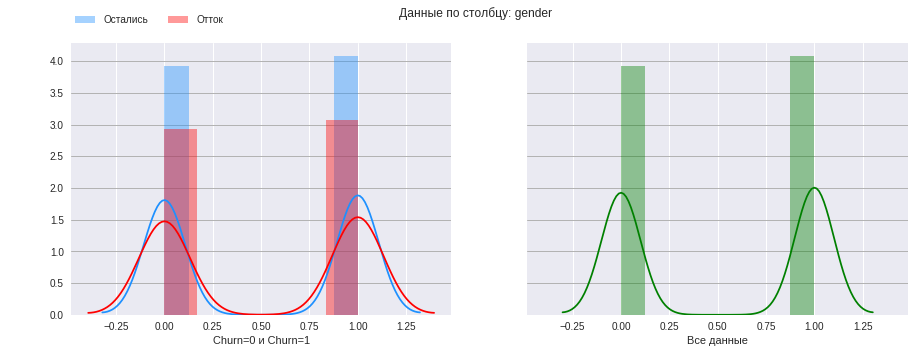

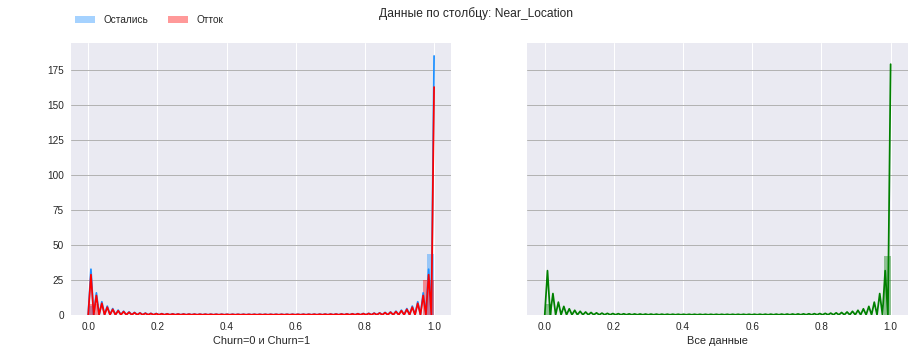

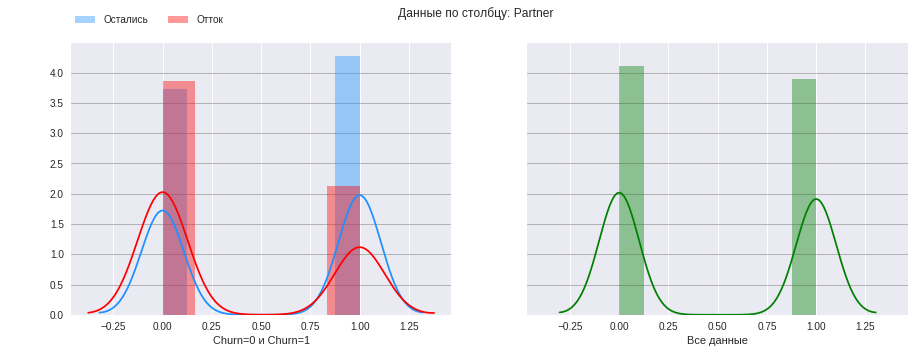

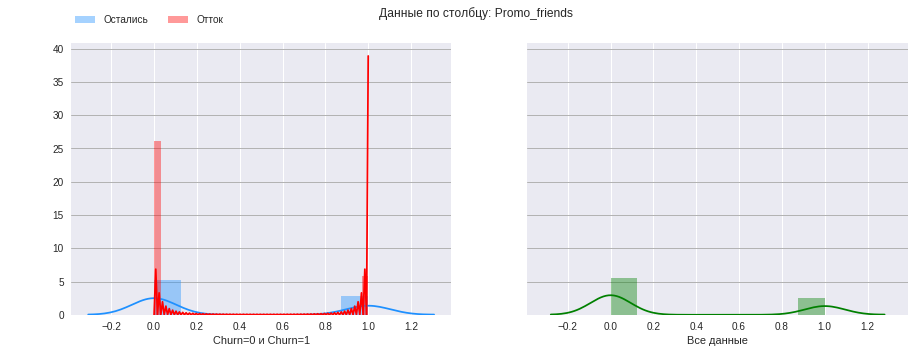

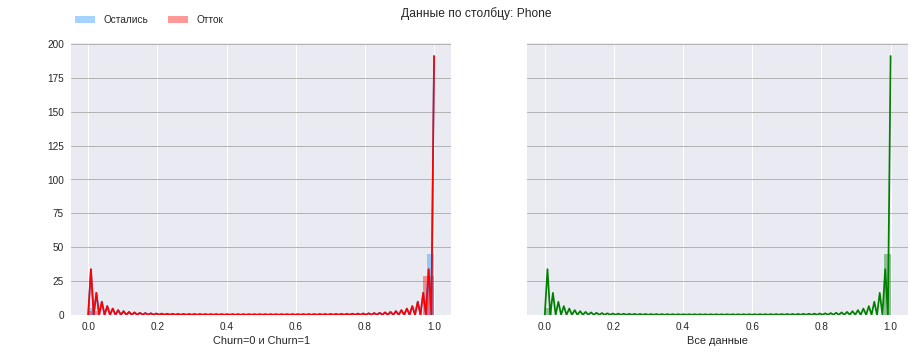

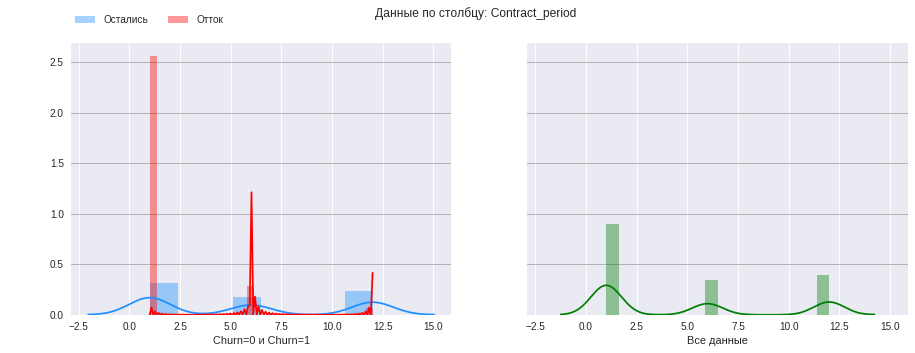

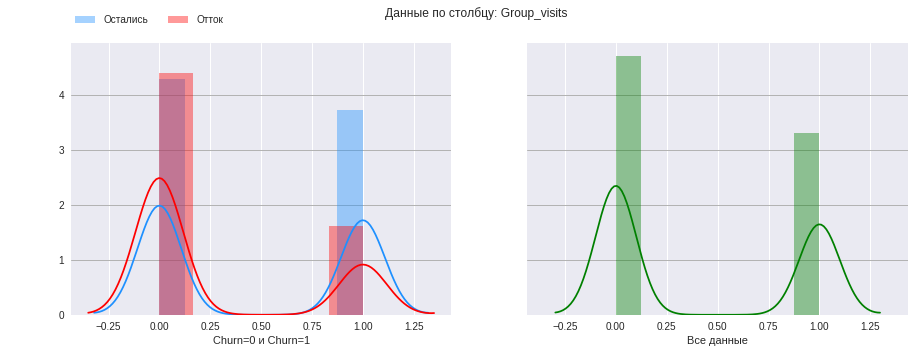

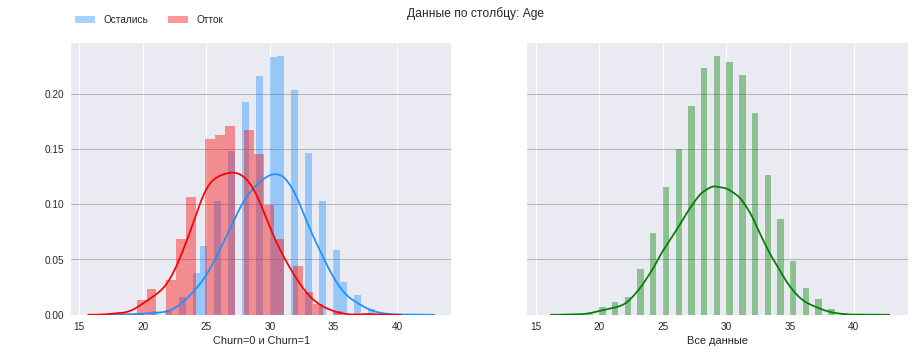

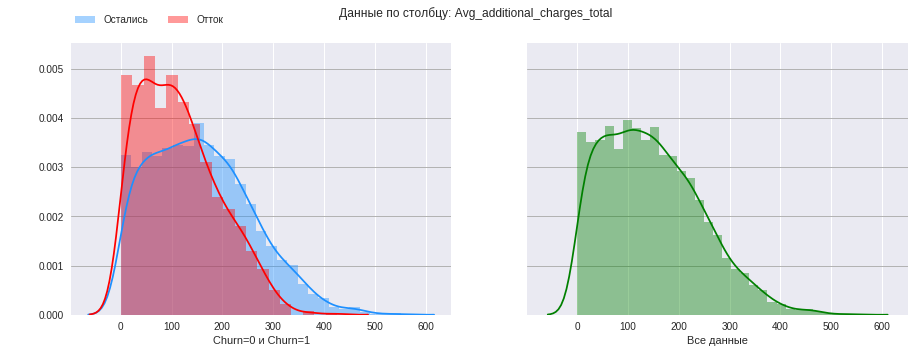

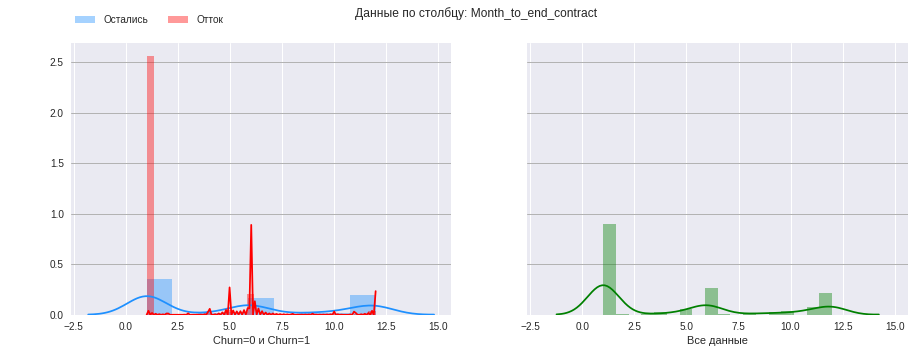

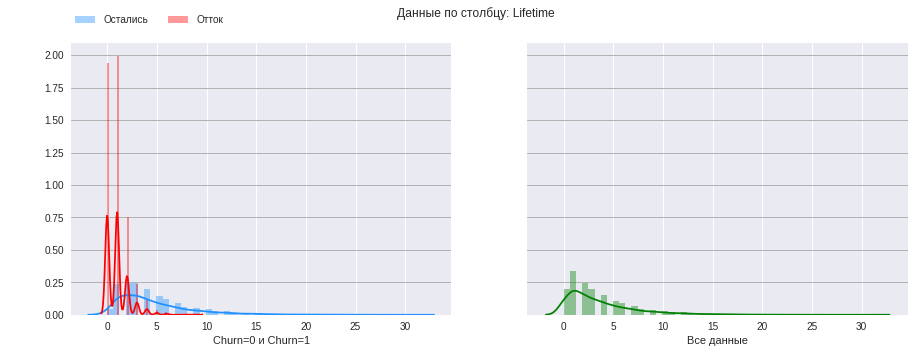

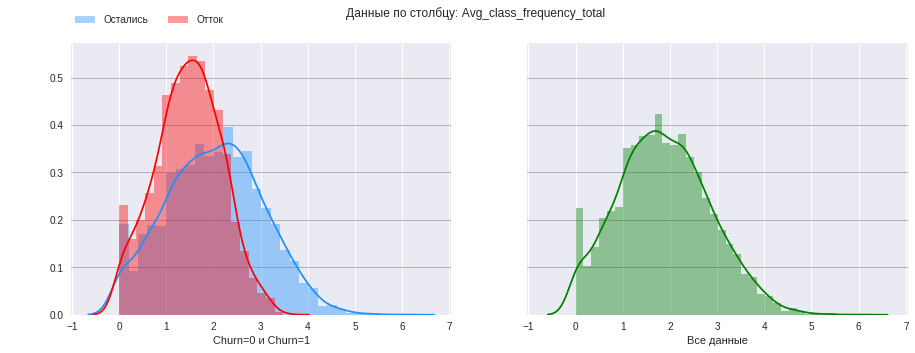

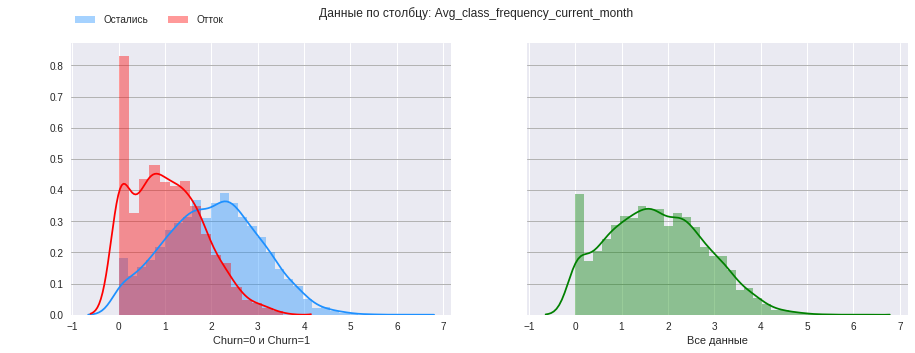

In [11]:
# построение графиков
for i in gym_churn.drop('Churn', axis = 1).columns:
    x1 = gym_churn_0[i]
    x2 = gym_churn_1[i]
    x3 = gym_churn[i]

    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
    fig.suptitle('Данные по столбцу: {}'.format(i))
    sns.distplot(x1 , color="dodgerblue", ax=axes[0], label='Остались')
    sns.distplot(x2 , color="red", ax=axes[0], axlabel='Churn=0 и Churn=1', label = 'Отток')
    sns.distplot(x3 , color="green", ax=axes[1], axlabel='Все данные')
    fig.legend(bbox_to_anchor=(0.066, 0.9), loc='lower left', ncol=2, borderaxespad=0.)
    axes[0].grid(axis='y', color='0.7')
    axes[1].grid(axis='y', color='0.7')
    plt.show()

Выявили следующие признаки клиентов из доли оттока:
- Promo_friends таких клиентов больше. Т.е. основная часть людей, которая приходит по совету друзей ненадежная.
- Contact_period таких людей до 2 месяцев. Т.е. если клиент ходит в зал более 2х месяцев, то скорее всего он будет и дальше ходить.
- Age 25-27 примерно. Клиенты до 27 лет менее надежны, чем клиенты 28-31. При этом основная часть общего числа клиентов до 31 года включительно
- Avg_additional_charges_total надежных клиентов больше.
- Среднее количество посещений за неделю для ненадежных клиентов в основном - 1 раз, в то время как надежные обычно ходят 2 или более раз.
- lifetime менее месяца, т.е. чем больше клиент ходит в зал, тем меньше вероятность его ухода в дальнейшем.

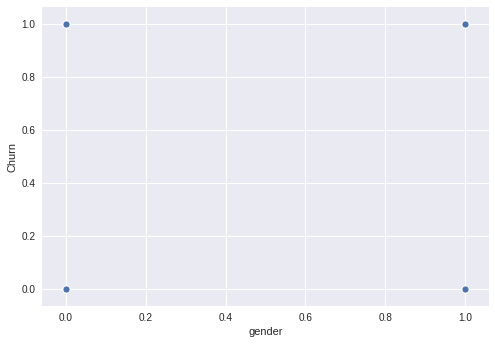

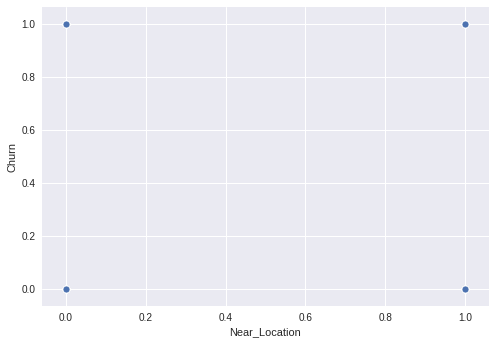

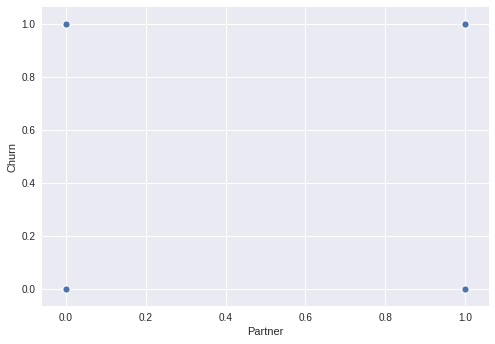

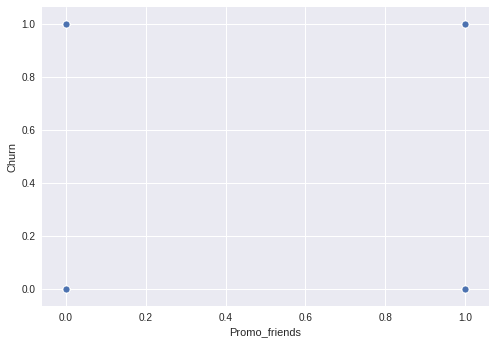

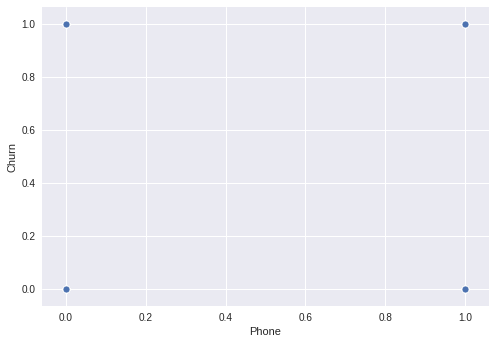

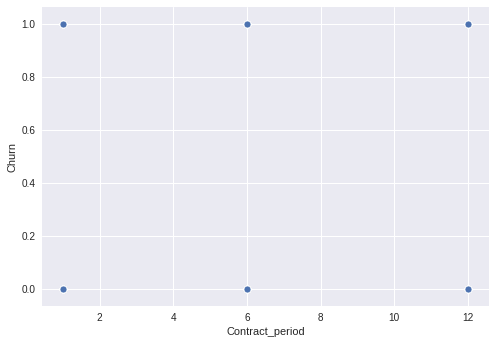

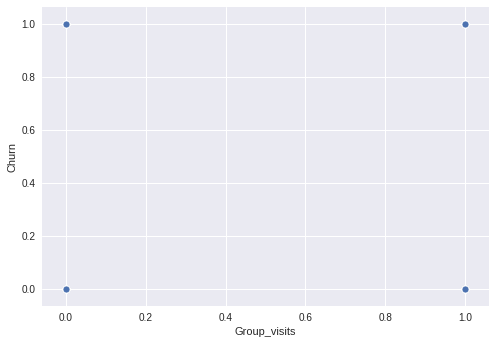

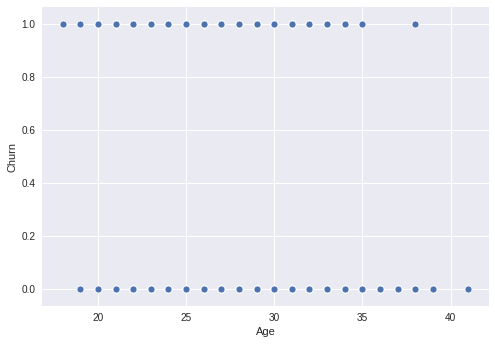

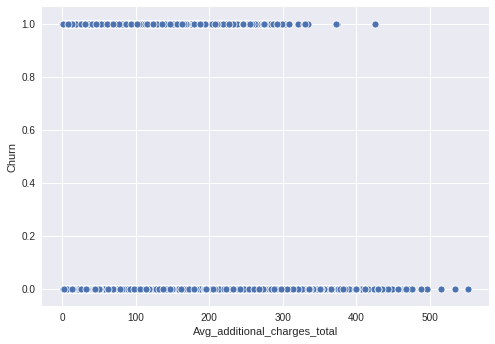

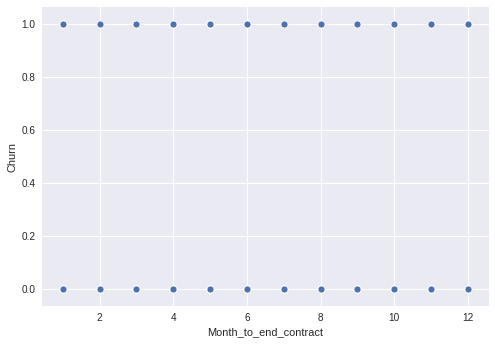

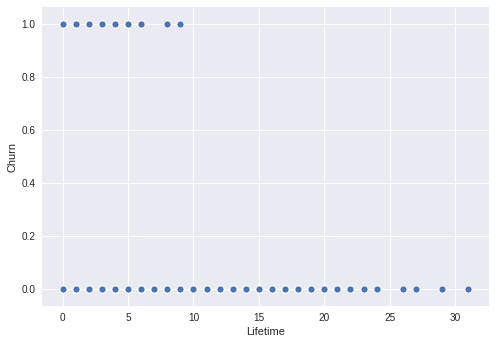

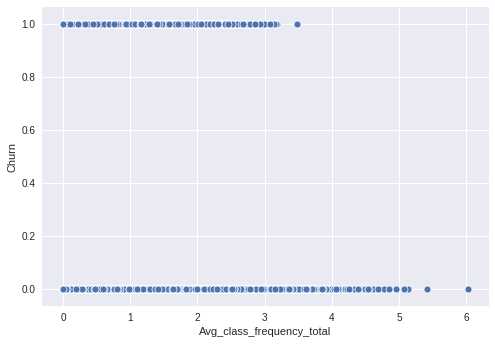

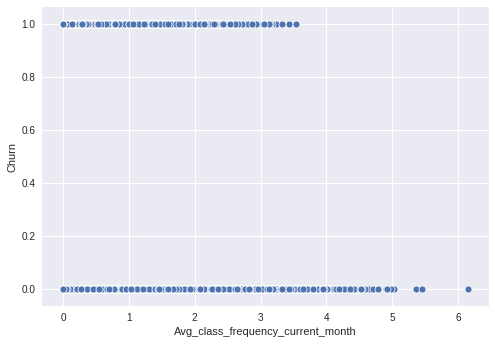

In [12]:
# Отрисовка попарных графиков
#sns.scatterplot(gym_churn['gender'], gym_churn['Near_Location'])
for col in gym_churn.drop('Churn', axis = 1).columns:
    sns.scatterplot(gym_churn[col], gym_churn['Churn'], palette = 'Paired'
       )  
    plt.show()

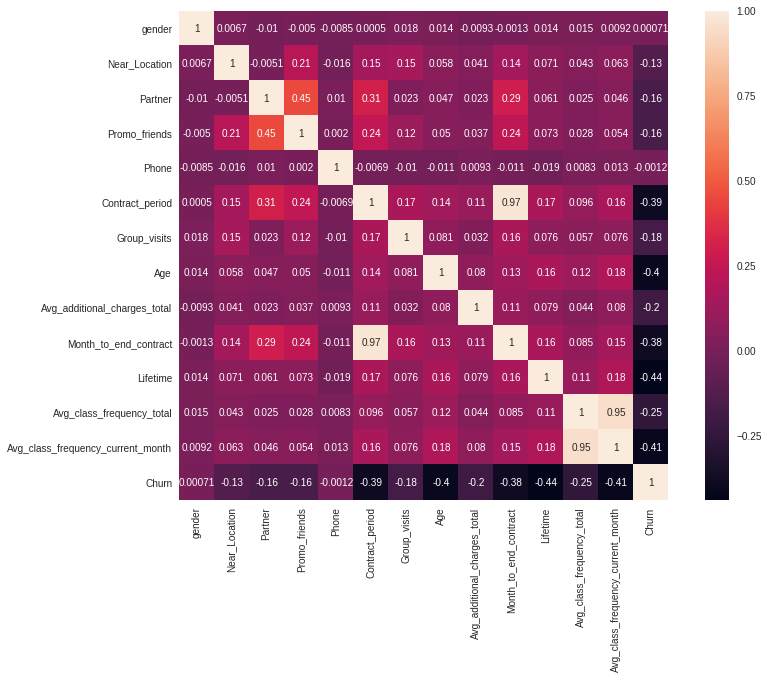

In [13]:
cm = gym_churn.corr() # .drop('Churn', axis = 1).corr() #вычисляем матрицу корреляций
plt.figure(figsize=(13, 9))
sns.heatmap(cm, xticklabels=cm.columns, yticklabels=cm.columns, square = True, annot = True) 
plt.show()

Сильно коррелируют: Avg_class_frequency_total и Avg_class_frequency_current_month - 0.95 и Contract_period и Month_to_end_contract - 0.97. Чтобы избавиться от мультиколлинеарности, удалим из датафрейма один из них - Avg_class_frequency_total и Month_to_end_contract.

In [14]:
gym_churn.drop('Avg_class_frequency_total', axis = 1, inplace = True) # убираем один из пары коррелирующих признаков

In [15]:
gym_churn.drop('Month_to_end_contract', axis = 1, inplace = True) # убираем один из пары коррелирующих признаков

#### Вывод

Анализ показал, что в таблице нет пропусков и дубликатов.

Кроме того, не требуется преобразований категориальных переменных.

При анализе не выявлено больших отклонений от среднего, соответственно предполага. отсутствие выбровов в данных.
Отсутствующие признаки в данных не выявлены. Общий процент оттока 27%.

Матрица корреляции показала следующие явные зависимости:
- Contract_period и Month_to_end_contract - 0.97
- Avg_class_frequency_total и Avg_class_frequency_current_month - 0.95.
Удалены колонки: Avg_class_frequency_current_month и Month_to_end_contract, чтобы избавиться от мультиколлинеальности.
Кроме того, исходя из матрицы корреляции можно сделать вывод о важности признаков: lifetime, Avg_class_frequency_current_month, 
Выявили следующие признаки клиентов из доли оттока:
- Promo_friends таких клиентов больше. Т.е. основная часть людей, которая приходит по совету друзей ненадежная.
- Contact_period таких людей до 2 месяцев. Т.е. если клиент ходит в зал более 2х месяцев, то скорее всего он будет и дальше ходить.
- Age 25-27 примерно. Клиенты до 27 лет менее надежны, чем клиенты 28-31. При этом основная часть общего числа клиентов до 31 года включительно
- Avg_additional_charges_total надежных клиентов больше.
- Среднее количество посещений за неделю для ненадежных клиентов в основном - 1 раз, в то время как надежные обычно ходят 2 или более раз.
- lifetime менее месяца, т.е. чем больше клиент ходит в зал, тем меньше вероятность его ухода в дальнейшем.

### <a id="model">3. Модель прогнозирования оттока пользователей</a>

In [16]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop('Churn', axis = 1)
y = gym_churn['Churn']

In [17]:
#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

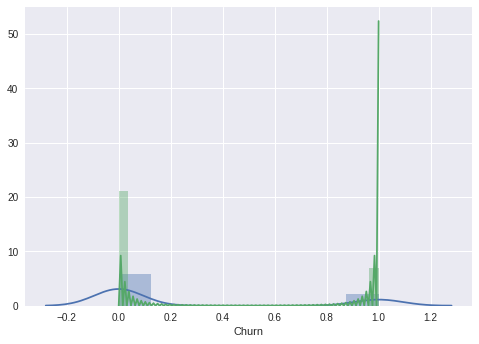

In [18]:
# гистограмма целевой переменной на train
sns.distplot(y_train)

# гистограмма целевой переменной на test
sns.distplot(y_test)

In [19]:
# создадим объект класса StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [20]:
# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train) #обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_test_st = scaler.transform(X_test)

In [21]:
# список моделей
models = [LogisticRegression(random_state = 0), RandomForestClassifier(n_estimators = 100, random_state = 0)]

In [22]:
for i in models:
    model = i
    # обучим модель
    model.fit(X_train_st, y_train)
    # воспользуемся уже обученной моделью, чтобы сделать прогнозы
    predictions = model.predict(X_test_st)
    probabilities = model.predict_proba(X_test_st)[:,1]
    # выведем все метрики
    print('Метрики для модели {}'.format(i))
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('\tRecall: {:.2f}'.format(recall_score(y_test, predictions)))
    print('\tF1: {:.2f}'.format(f1_score(y_test, predictions)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Метрики для модели LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.82
	F1: 0.81
	ROC_AUC: 0.96
Метрики для модели RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
	Accuracy: 0.90
	Precision: 0.81
	Recall: 0.75
	F1: 0.78
	ROC_AUC: 0.95


#### Вывод

По результатам расчета метрик для моделей LogisticRegression и RandomForestClassifier получили следующие результаты:
- LogisticRegression:
    - Accuracy: 0.90
	- Precision: 0.79
	- Recall: 0.81
	- F1: 0.80
	- ROC_AUC: 0.95
- RandomForestClassifier:
    - Accuracy: 0.89
	- Precision: 0.79
	- Recall: 0.76
	- F1: 0.77
	- ROC_AUC: 0.94
Видно, что результаты модели LogisticRegression немного лучше по всем метрикам кроме Precision(тут одинаковый результат).
Однако, надо отметить, что обе модели показали хорошие результаты и разница между ними не очень большая.

### <a id="clustering">4. Кластеризация пользователей</a>

In [23]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
x_sc = sc.fit_transform(X)

km = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров, равное 5
labels = km.fit_predict(x_sc) # применяем алгоритм к данным и формируем вектор кластеров

In [24]:
# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels

In [25]:
# выводим статистику по средним значениям наших признаков по кластеру
gym_churn_group = gym_churn.groupby(['cluster_km']).mean()
gym_churn_group

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,
0,0.50,1.00,0.89,1.00,1.00,6.92,0.52,29.61,153.42,4.28,1.92,0.12
1,0.50,0.00,0.49,0.08,1.00,2.99,0.23,28.68,137.13,2.97,1.60,0.40
2,0.50,1.00,0.22,0.07,1.00,2.01,0.28,27.58,119.34,1.92,1.20,0.56
3,0.53,1.00,0.38,0.01,1.00,6.21,0.54,30.70,176.26,5.42,2.32,0.01
4,0.52,0.86,0.47,0.31,0.00,4.78,0.43,29.30,144.21,3.94,1.72,0.27


Проценты оттока по кластерам:
- 0 - 40%
- 1 - 12%
- 2 - 38%
- 3 - 20%
- 4 - 27%.

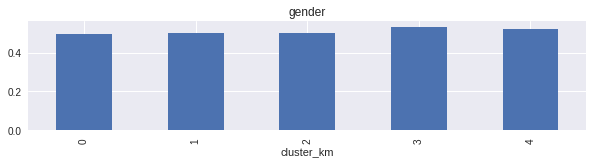

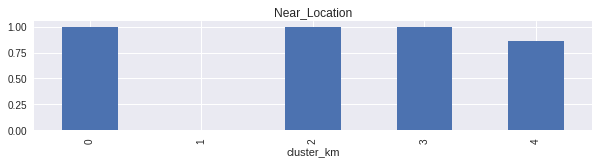

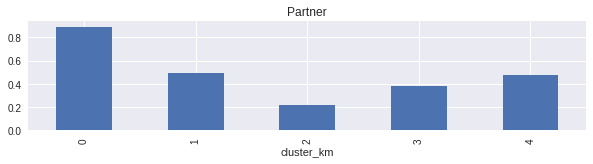

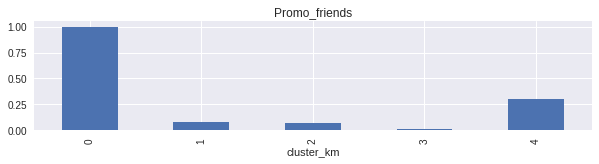

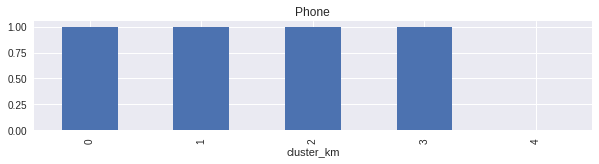

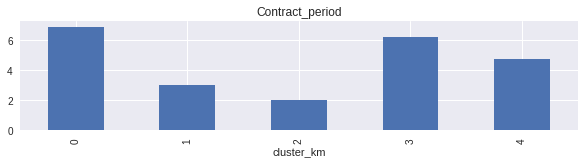

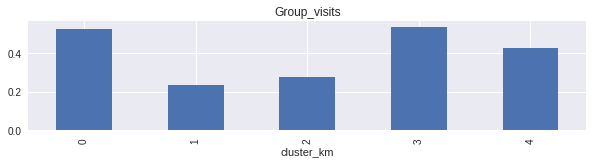

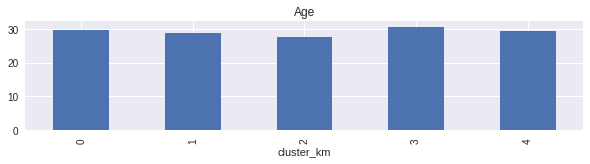

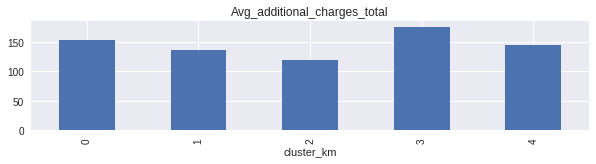

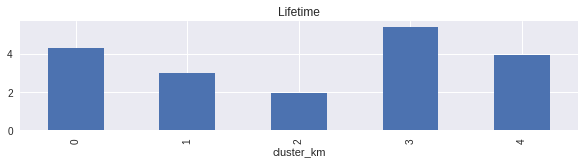

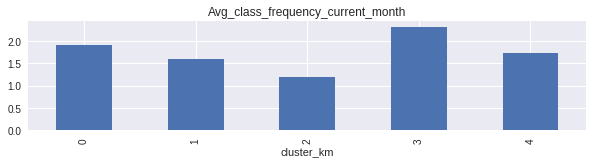

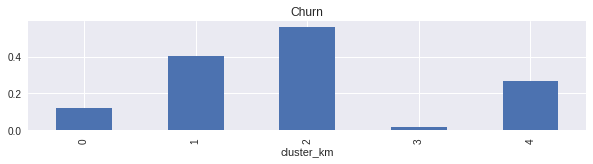

In [26]:
for i in gym_churn_group.columns:
    plt.title(i)
    gym_churn_group[i].plot(kind='bar', figsize=(10, 2))
    plt.show()

In [27]:
gym_churn.groupby(['cluster_km'])['gender'].count()

cluster_km
0     985
1     558
2    1064
3    1007
4     386
Name: gender, dtype: int64

Попробуем сформулировать признаки кластеров:

- 0 - самый ненадежный кластер. Отличительней признаки: Near_Location=0, Promo_friends низкий процент, Contract_period небольшой.

- 1 - самый надежный и довольно многочисленный кластер. Отличительные признаки: Near_Location=1, Partner=1, Promo_friends самый большой, Contract_period самый большой.

- 2 - самый многочисленный и достаточно ненадежный кластер. Отличительные признаки: Near_Location=1, Partner небольшой процент, Promo_friends низкий процент, Contract_period самый маленький, Group_visits=0.

- 3 - Отличительные признаки: Near_Location=1, Partner небольшой процент, Promo_friends низкий процент, Group_visits=1. 

- 4 - самый немногочисленный кластер. Отличительный признак: Phone=0.

0 и 2 - самые ненадежные. 1 и 3 самые надежные. 4-й самый немногочисленный и не отличается надежностью.

In [28]:
linked = linkage(x_sc, method = 'ward')

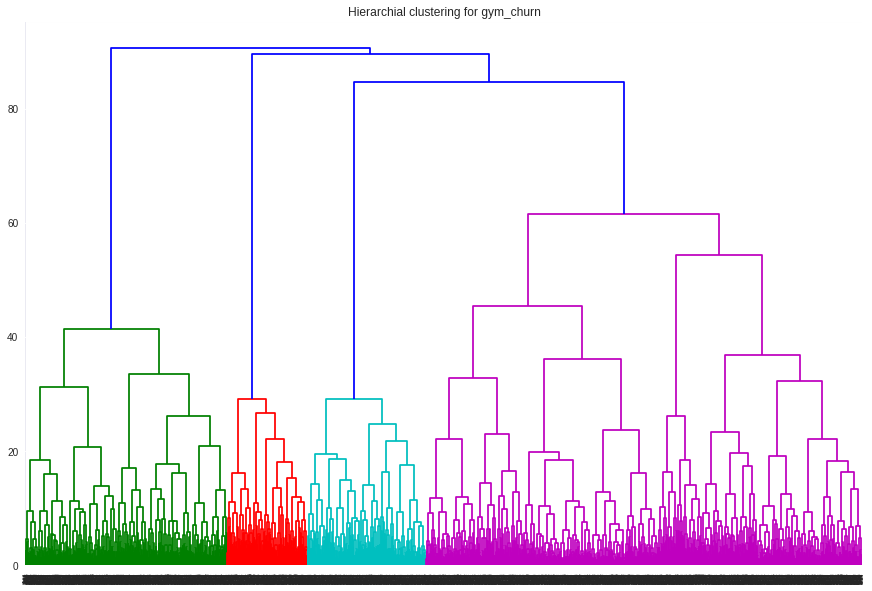

In [29]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for gym_churn')
plt.show()

In [30]:
gym_churn.groupby(['cluster_km', 'Churn']).mean()

gender  Near_Location  Partner  Promo_friends  Phone  \
cluster_km Churn                                                         
0          0        0.50           1.00     0.88           1.00   1.00   
           1        0.47           1.00     0.97           1.00   1.00   
1          0        0.50           0.00     0.56           0.10   1.00   
           1        0.50           0.00     0.39           0.04   1.00   
2          0        0.48           1.00     0.22           0.06   1.00   
           1        0.52           1.00     0.21           0.09   1.00   
3          0        0.53           1.00     0.38           0.01   1.00   
           1        0.67           1.00     0.40           0.00   1.00   
4          0        0.52           0.89     0.50           0.36   0.00   
           1        0.52           0.80     0.39           0.16   0.00   

                  Contract_period  Group_visits   Age  \
cluster_km Churn                                        
0          0                 7.52          0.55 29.94   
           1                 2.53          0.36 27.13   
1          0                 4.00          0.28 29.83   
           1                 1.50          0.16 26.97   
2          0                 2.54          0.29 28.54   
           1                 1.60          0.27 26.84   
3          0                 6.25          0.53 30.69   
           1                 3.47          0.80 31.00   
4          0                 5.86          0.46 30.08   
           1                 1.80          0.33 27.15   

                  Avg_additional_charges_total  Lifetime  \
cluster_km Churn                                           
0          0                            158.10      4.74   
           1                            119.05      0.93   
1          0                            150.06      4.31   
           1                            117.99      1.00   
2          0                            128.53      3.13   
           1                            112.24      0.99   
3          0                            175.95      5.47   
           1                            196.51      1.80   
4          0                            157.05      5.03   
           1                            108.92      0.95   

                  Avg_class_frequency_current_month  
cluster_km Churn                                     
0          0                                   2.03  
           1                                   1.09  
1          0                                   2.00  
           1                                   1.00  
2          0                                   1.42  
           1                                   1.04  
3          0                                   2.33  
           1                                   1.76  
4          0                                   1.97  
           1                                   1.06

#### Вывод

Проценты оттока по кластерам:
- 0 - 40% (561 клиент)
- 1 - 12% (1050 клиентов)
- 2 - 38% (1132 клиентов)
- 3 - 20% (871 клиент)
- 4 - 27% (386 клиентов).

Соответственно очевидно самые надежные кластеры 1 и 3. Самые склонные к оттоку кластеры - 0 и 2.
4 кластер самый немногочисленный, недостаточно надежный. Отличительная особенность - клиенты не оставляют номер телефона. В принципе самый "средний" по всем параметрам кластер.

0 кластер самый ненадежный, однако, довольно небольшой по количеству клиентов. Отличительными особенностями кластера являются:Near_Location=0, Promo_friends низкий процент, Contract_period небольшой. 

1 кластер - самый надежный и довольно многочисленный. Отличительными особенностями кластера являются:Near_Location=1, Partner=1, Promo_friends самый большой, Contract_period самый большой.

2 кластер - ненадежный, но самый многочисленный. Отличительные признаки: Near_Location=1, Partner небольшой процент, Promo_friends низкий процент, Contract_period самый маленький, Group_visits=0.

3 кластер - относительно надежный и средний по численности. Отличительные признаки: Near_Location=1, Partner небольшой процент, Promo_friends низкий процент, Group_visits=1(отличает тот 2 кластера). 


Что же отличает более надежные кластеры:
1) высокий Promo_friends - ходить с друзьями веселее и лучше дисциплинирует;
2) фитнес-центр находится рядом с домом или работой - логично, мало времени уходит на дорогу. ключевой признак, на него не можем повлиять.
3) сотрудничество с компаниями - скорее всего сотрудникам дают скидки на длительные абонементы. ключевой признак.
4) более длительные абонементы - видимо, клиент уже убедился в качестве услуг или просто серьезно настроен.
5) Больше ходят на групповые занятия.


Что же отличает ненадежные кластеры:
1) фитнес-центр находится далеко от работы и дома  - логично, много времени уходит на дорогу. ключевой признак, на него не можем повлиять.
2) Клиенты преимущественно не ходят на групповые занятия.
3) низкий Promo_friends.
4) Contract_period небольшой или маленький. Видимо, абонемент брали на пробу или подарили.

# Вывод

На основании полученных результатов особенностей надежных и менее надежных клестеров стоит попробовать следующие действия по улучшению:
- увеличить разнообразие групповых занятий и проводить информирование клиентов о наличии групповых занятий;
- провести анализ офисов компаний рядом с фитнес-центром и рассчитать предложения для таких офисов(возможно, предложить скидку на годовые абонементы);
- провести информирование жителей, проживающих не более чем в 1 км от фитнес-клуба (в случае если фитнес-клуб недавно открыт или заселились новые дома);
- наверное самый стандартный способ - скидки на годовые абонементы и на продление абонемента.

При проведении рекламы и других маркетинговых действиях необходимо ориентироваться на основную возрастную категорию - 25-31.
Возможно, стоит задуматься о привлечении других возрастных категорий. однако, это потребует больших вложений в новые групповые занятия, тренажеры, тренерский состав.